In [1]:
import gym

In [2]:
import retro
import time

In [3]:
retro.data.list_games()

['1942-Nes',
 '1943-Nes',
 '3NinjasKickBack-Genesis',
 '8Eyes-Nes',
 'AaahhRealMonsters-Genesis',
 'AbadoxTheDeadlyInnerWar-Nes',
 'AcceleBrid-Snes',
 'ActRaiser2-Snes',
 'ActionPachio-Snes',
 'AddamsFamily-GameBoy',
 'AddamsFamily-Genesis',
 'AddamsFamily-Nes',
 'AddamsFamily-Sms',
 'AddamsFamily-Snes',
 'AddamsFamilyPugsleysScavengerHunt-Nes',
 'AddamsFamilyPugsleysScavengerHunt-Snes',
 'AdvancedBusterhawkGleylancer-Genesis',
 'Adventure-Atari2600',
 'AdventureIsland-GameBoy',
 'AdventureIsland3-Nes',
 'AdventureIslandII-Nes',
 'AdventuresOfBatmanAndRobin-Genesis',
 'AdventuresOfBayouBilly-Nes',
 'AdventuresOfDinoRiki-Nes',
 'AdventuresOfDrFranken-Snes',
 'AdventuresOfKidKleets-Snes',
 'AdventuresOfMightyMax-Genesis',
 'AdventuresOfMightyMax-Snes',
 'AdventuresOfRockyAndBullwinkleAndFriends-Genesis',
 'AdventuresOfRockyAndBullwinkleAndFriends-Nes',
 'AdventuresOfRockyAndBullwinkleAndFriends-Snes',
 'AdventuresOfStarSaver-GameBoy',
 'AdventuresOfYogiBear-Snes',
 'AeroFighters-Snes',
 

In [4]:
from gym import Env
from gym.spaces import MultiBinary, Box
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [5]:
class StreetFighter(Env):
    def __init__(self):
        super().__init__()
        #action space and obs space
        self.observation_space = Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.action_space = MultiBinary(12)
        #start game instance
        self.game = retro.make(game='StreetFighterIISpecialChampionEdition-Genesis', 
                               use_restricted_actions=retro.Actions.FILTERED)
    
    def step(self, action):
        obs, reward, done , info = self.game.step(action)
        obs = self.preprocess(obs)

        frame_delta = obs - self.previous_frame
        self.previous_frame = obs

        reward = info['score'] - self.score
        self.score = info['score'] 

        return frame_delta, reward, done, info
    
    def render(self, *args, **kwargs):
        self.game.render()
    
    def reset(self):
        obs = self.game.reset()
        obs = self.preprocess(obs)
        self.previous_frame = obs
        
        #change in score is the reward function
        self.score = 0
        return obs
    
    def preprocess(self, observation):
        #grayscale
        gray = cv2.cvtColor(observation, cv2.COLOR_BGR2GRAY)
        #resize
        resize = cv2.resize(gray, (84, 84), interpolation=cv2.INTER_CUBIC)
        #add channels value
        channels = np.reshape(resize, (84, 84, 1))
        
        return channels
    
    def close(self):
        self.game.close()

In [6]:
env = StreetFighter()

In [7]:
env.observation_space.shape

(84, 84, 1)

In [11]:
obs = env.reset()
done = False
for game in range(1):
    while not done:
        if done:
            obs = env.reset()
        env.render()
        obs, reward, done, info = env.step(env.action_space.sample())
        time.sleep(0.01)
        if reward > 0:
            print(reward)

500
1000
500
1000
500
500
500
300
500
1500
100
100
100
100
100
100
100
100
100
100
100
100
100
1000
1000
1000
1000
1000
1000
500
500
300


KeyboardInterrupt: 

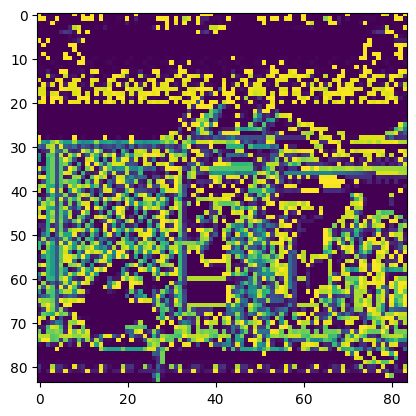

In [10]:
plt.imshow(obs)